# Time series regression
We attempt to predict continuous values from short time series.

We generate synthetic data with a range of frequencies, amplitudes, phases and noise, and fit frequency and amplitude.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(gridlines=':')

## Helper functions to generate synthetic data

In [7]:
def timeseries(n=100, freq=1, A=1, phase=0, noise=0.1):
    # freq, A, phase and noise con be single values or arrays of the same length
    # in the latter case, the return array has shape (len(A), n)
    freq = np.reshape(freq, (-1, 1))
    A = np.reshape(A, (-1, 1))
    phase = np.reshape(phase, (-1, 1))
    noise = np.reshape(noise, (-1, 1))
    x = np.arange(n)
    return A*np.sin(2*np.pi*freq*x/n - phase) + noise*np.random.randn(n)

def timeseries_from_df(df, n=100):
    return timeseries(n=n, freq=df.freq, A=df.A, phase=df.phase, noise=df.noise)

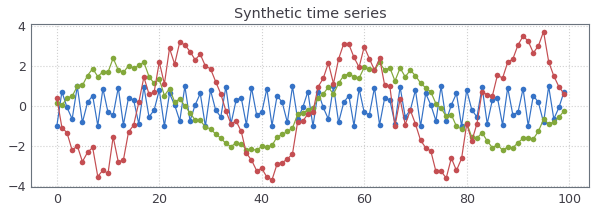

In [8]:
df = pd.DataFrame(columns=['A', 'freq', 'phase', 'noise'])
df.A = [1, 2, 3]
df.freq = [38, 2, 3]
df.phase = [np.pi/2, 0, np.pi]
df.noise = [0, 0.2, 0.5]

X = timeseries_from_df(df=df)

plt.figure(figsize=(10, 3))
plt.plot(X.T, 'o-');
plt.title('Synthetic time series')
pass

## Fixed length, MLPR
The simplest case is to look at time series windowed to a fixed length - the only input suitable for a simple MLP architecture.

In [9]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

### Create synthetic data

50000 training examples


,A,freq,noise
43109,0.2,10.0,0.0
46322,0.5,23.0,0.0
35120,0.0,21.0,0.0
48363,0.3,14.0,0.0


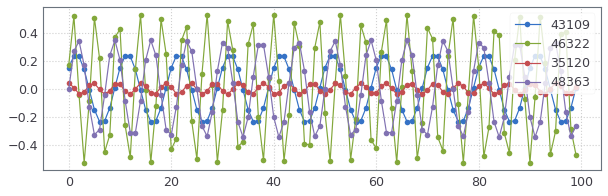

In [10]:
import itertools
# specify ranges of parameters
params = dict(
    A=np.linspace(0, 1, 50),
    freq=np.linspace(1, 50, 50),
    phase=np.linspace(0, 2*np.pi, 20),
    noise=[0.],
)
# create all possible combinations
df = pd.DataFrame(
    list(itertools.product(*params.values())),
    columns=params.keys()
)
# create time series
X = timeseries_from_df(df=df)
# get feature array
y = df[['A', 'freq']].values

print '%d training examples' % len(df)
# plot random subset of data
rand_idx = np.random.choice(X.shape[0], 4)
plt.figure(figsize=(10, 3))
plt.plot(X[rand_idx].T, 'o-');
plt.legend(rand_idx)
df.loc[rand_idx, ['A', 'freq', 'noise']].round(1)

### Split into test and train set

In [11]:
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, df.index, test_size=0.2, random_state=0)

### Create and fit NN model

In [12]:
%%time
model = MLPRegressor(hidden_layer_sizes=(100, 100, 100))
model.fit(X_train, y_train)

CPU times: user 1min 28s, sys: 3min 16s, total: 4min 44s
Wall time: 38.6 s


In [13]:
print 'train: ', model.score(X_train, y_train)
print 'test: ', model.score(X_test, y_test)

train:  0.972040324854
test:  0.973519065565


### Analize predictions

In [14]:
f = model.predict(X)
df['A_f'], df['freq_f'] = f[:, 0], f[:, 1]

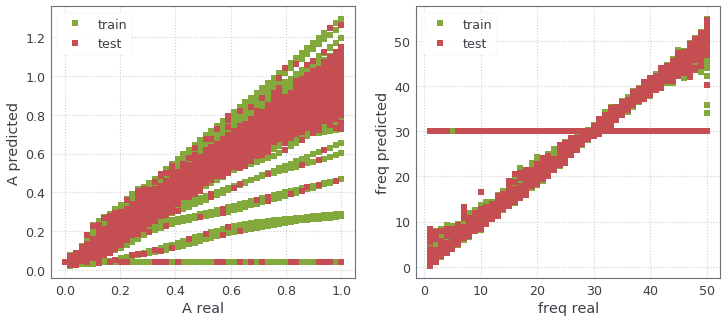

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, field in zip(axes, ['A', 'freq']):
    ax.plot(df[field][idx_train], df[field+'_f'][idx_train], 'gs', label='train')
    ax.plot(df[field][idx_test], df[field+'_f'][idx_test], 'rs', label='test')
    ax.legend()
    ax.set_xlabel('%s real' % field)
    ax.set_ylabel('%s predicted' % field)

#### Amplitude prediction error
Frequencies approaching Niquist lead to mis-clasification in amplitude!

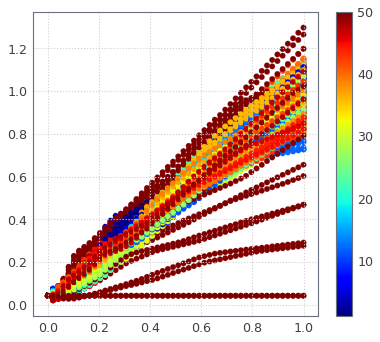

In [16]:
plt.scatter(df.A, df.A_f, c=df.freq, cmap=plt.cm.jet)
plt.colorbar()

In [17]:
from sklearn.metrics import r2_score

In [18]:
print r2_score(df[df.freq<45].A, df[df.freq<45].A_f)
print r2_score(df[df.freq>45].A, df[df.freq>45].A_f)

0.981415492142
0.832733961211


#### Frequency prediction error
- constant freq. comes from 0 amplitude
- larger errors come from small amplitude
- large error at Niquist

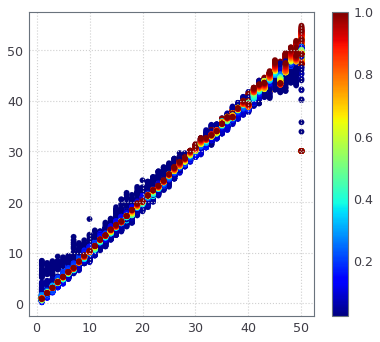

In [19]:
plt.scatter(df[df.A>0].freq, df[df.A>0].freq_f, c=df[df.A>0].A, cmap=plt.cm.jet)
plt.colorbar()

In [20]:
df['A_err'] = abs(1 - df.A/df.A_f)
df['freq_err'] = abs(1 - df.freq/df.freq_f)

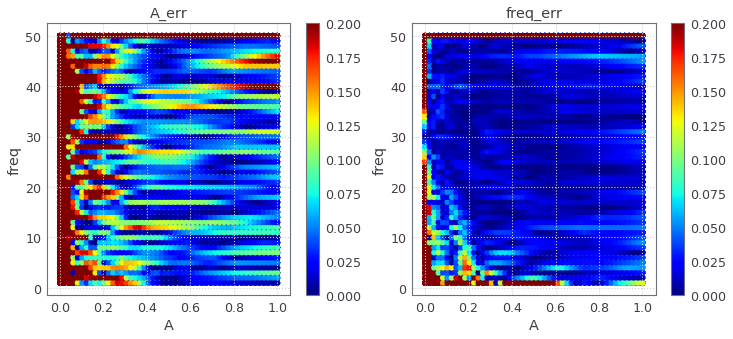

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, field in zip(axes, ['A', 'freq']):
    sp = ax.scatter(df.A, df.freq, c=df[field+'_err'], cmap=plt.cm.jet, vmin=0, vmax=0.2)
    plt.colorbar(sp, ax=ax)
    ax.set_title(field+'_err')
    ax.set_xlabel('A')
    ax.set_ylabel('freq')

In [22]:
### Try a new unseen dataseries
ts = timeseries(A=0.3, freq=12.3, phase=0.1, noise=0.1)
model.predict(ts)

array([[  0.33389577,  12.68506292]])

#### Overall, freq. prediction appears more robust, esp. with smaller network

- [ ] test with noisy series